**1. Downloading the corpus**

In [1]:
import keras
import nltk
nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
print(len(austen)) #sanity check

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
16498


In [2]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**2.PREPROCESSING THE TRAINING CORPUS**

In [32]:
import string
normalised_corpus =[]
for sentence in austen:
  sentences =[]
  for word in sentence:
    word = word.lower()
    word = word.strip(string.punctuation)
    word = word.strip(string.digits)
    if word not in string.punctuation and word not in stop_words: 
      sentences.append(word)
  if(len(sentences)>2):
    normalised_corpus.append(sentences)

#sanity check
print("length of processed corpus: ",len(normalised_corpus))
print(" processed line: ",normalised_corpus[10])

length of processed corpus:  13927
 processed line:  ['therefore', 'succession', 'norland', 'estate', 'really', 'important', 'sisters', 'fortune', 'independent', 'might', 'arise', 'father', 'inheriting', 'property', 'could', 'small']


**3.Corpus Vocabulary and preparing dataset**

In [0]:
#creating word2idx, idx2word, sents_as_ids
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(normalised_corpus)

word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
sents_as_ids = tokenizer.texts_to_sequences(normalised_corpus)

vocab_size = len(word2idx) + 1
embed_size = 100

In [34]:
#SANITY CHECK
print("number of unique words: ",len(word2idx))
print("word2idx: ",list(word2idx.items())[:10])
print("idx2word: ",list(idx2word.items())[:10])
print("normalised corpus: ",normalised_corpus[:3])
print("lists_as_ids: ",sents_as_ids[:3])

number of unique words:  10098
word2idx:  [('could', 1), ('would', 2), ('mr', 3), ('mrs', 4), ('must', 5), ('said', 6), ('one', 7), ('much', 8), ('miss', 9), ('every', 10)]
idx2word:  [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]
normalised corpus:  [['sense', 'sensibility', 'jane', 'austen'], ['family', 'dashwood', 'long', 'settled', 'sussex'], ['estate', 'large', 'residence', 'norland', 'park', 'centre', 'property', 'many', 'generations', 'lived', 'respectable', 'manner', 'engage', 'general', 'good', 'opinion', 'surrounding', 'acquaintance']]
lists_as_ids:  [[305, 1379, 75, 4299], [108, 101, 57, 333, 2588], [1022, 405, 1627, 597, 554, 2784, 1023, 66, 4300, 512, 768, 160, 1164, 199, 15, 190, 3044, 147]]


**4.Generating training instances**

In [0]:
from keras.preprocessing.sequence import skipgrams
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in sents_as_ids]

In [7]:
#sanity check
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
  print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
# the first word and its index
idx2word[pairs[i][0]], pairs[i][0],
# the second word and its index
idx2word[pairs[i][1]], pairs[i][1],
# the label
labels[i]))


(austen (4299), decisive (2984)) -> 0
(sensibility (1379), claiming (4510)) -> 0
(sense (305), austen (4299)) -> 1
(austen (4299), sensibility (1379)) -> 1
(jane (75), diminished (5116)) -> 0
(austen (4299), robust (10011)) -> 0
(sensibility (1379), insurmountable (7097)) -> 0
(sensibility (1379), austen (4299)) -> 1
(austen (4299), sense (305)) -> 1
(sensibility (1379), seriously (997)) -> 0
(jane (75), tenacious (9312)) -> 0
(sense (305), sensibility (1379)) -> 1
(jane (75), sensibility (1379)) -> 1
(sense (305), derive (4661)) -> 0
(sensibility (1379), sense (305)) -> 1
(jane (75), appeal (2864)) -> 0
(jane (75), sense (305)) -> 1
(austen (4299), jane (75)) -> 1
(sense (305), jane (75)) -> 1
(sense (305), works (3105)) -> 0
(sense (305), lists (4847)) -> 0
(sensibility (1379), jane (75)) -> 1
(jane (75), austen (4299)) -> 1
(austen (4299), impassioned (9539)) -> 0


**5. Building the skip-gram Neural Network Architecture**

In [8]:
# A INIT AND TRANSFORM FIRST INPUT 
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')

# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer from whose weights we will get the word embeddings.
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer',embeddings_initializer='glorot_uniform',input_length=1)(target_word)

# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((embed_size, ))(target_embedding)

In [0]:
# B FOR CONTEXT WORD INPUT
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='Context_embed_layer',embeddings_initializer='glorot_uniform',input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)


In [0]:
# C MERGE INPUTS
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

In [0]:
# D PASS MERGED INPUTS INTO SIGMOID ACTIVATION LAYER
label = Dense(1,activation='sigmoid',kernel_initializer='glorot_uniform') (merged_inputs)

In [0]:
# E INIT THE MODEL
model =Model(inputs =[target_word,context_word],outputs =[label])

In [13]:
# F COMPILE THE MODEL
model.compile(loss='mean_squared_error',optimizer='rmsprop')

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1009900     input_1[0][0]                    
__________________________________________________________________________________________________
Context_embed_layer (Embedding) (None, 1, 100)       1009900     input_2[0][0]                    
____________________________________________________________________________________________

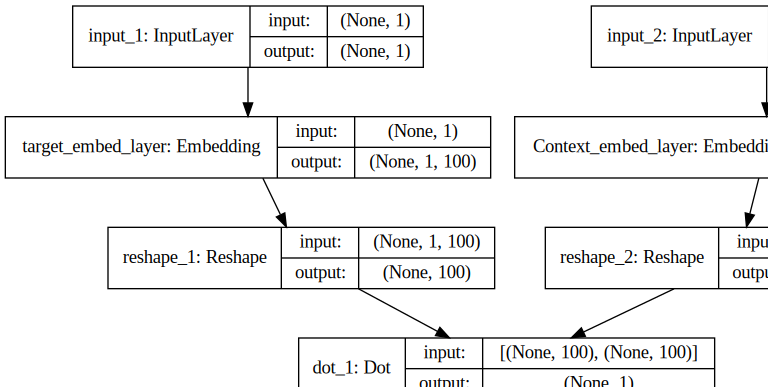

In [15]:
# VISUALISE MODEL ARCHITECTURE
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True,
show_layer_names=True).create(prog='dot', format='svg'))

**6. TRAINING THE MODEL**

In [16]:
import numpy as np
for epoch in range(1, 6):
  epoch_loss = 0
# in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
  for i, sent_examples in enumerate(skip_grams):
    target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
    context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
    labels = np.array(sent_examples[1], dtype='int32')
    X = [target_wds, context_wds]
    Y = labels
    if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
      print('Processed %d sentences' %i)
    epoch_loss += model.train_on_batch(X, Y)
  print('Processed all %d sentences' %i)
  print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences








Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 1 Loss: 2385.555643208325 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 2 Loss: 1953.0433087092824 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 3 Loss: 1872.2284584676381 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 4 Loss: 1828.892881149426 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 5 Loss: 1804.5949646137888 



**7. GETTING WORD EMBEDDINGS**

In [24]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:] # Recall that 0 was left for padding
print(word_embeddings.shape)
from pandas import DataFrame
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))


(10098, 100)
             0         1         2   ...        97        98        99
could -0.065566  0.241294  0.177027  ... -0.215455  0.088242  0.014046
would  0.064859  0.099706  0.009521  ...  0.003234 -0.104908  0.173007
mr     0.044055 -0.049779  0.085150  ... -0.243489 -0.147880  0.139317
mrs   -0.048754  0.068824 -0.007522  ... -0.187436 -0.081103  0.091996
must  -0.078067  0.014599  0.068045  ...  0.085418  0.178090  0.095712
said   0.094996  0.139068  0.039910  ... -0.264173 -0.187151  0.107189
one    0.115744 -0.019627  0.181293  ... -0.166394 -0.041761 -0.212671
much   0.028916 -0.016565  0.025584  ...  0.105369 -0.084623  0.158464
miss   0.121249 -0.084069 -0.180322  ... -0.108279 -0.146325  0.099114
every -0.186453  0.009653  0.107580  ...  0.175436 -0.171226  0.019069

[10 rows x 100 columns]


**8. MEASURING SIMILARITY BETWEEN WORD PAIRS**

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)
print(similarity_matrix.shape)

(10098, 10098)


**9. VISUALISE WORD EMBEDDINGS USING t-SNE**

In [0]:
search_items = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']
# Get the 5 words most similar to the search terms
similar_words = {term: [idx2word[idx]
for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1] for term in search_items}

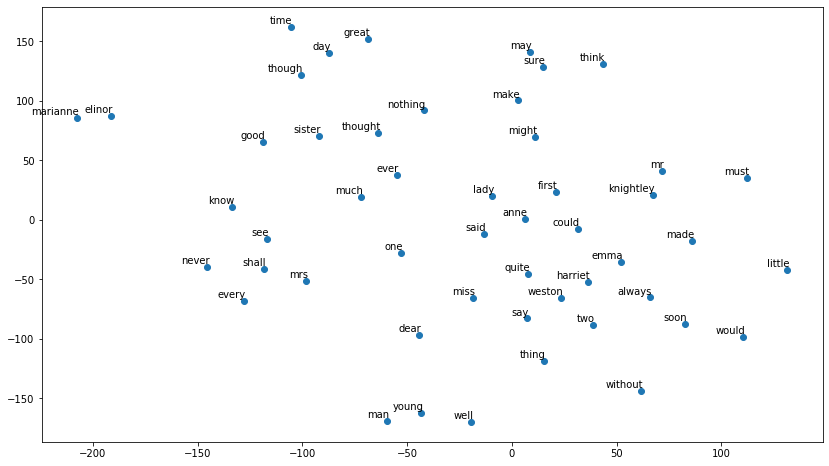

In [31]:
>>> from sklearn.manifold import TSNE
>>> import matplotlib.pyplot as plt
>>> tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
>>> np.set_printoptions(suppress=True)
>>> plot_only = 50
>>> T = tsne.fit_transform(word_embeddings[:plot_only, :])
>>> labels = [idx2word[i+1] for i in range(plot_only)]
>>> plt.figure(figsize=(14, 8))
>>> plt.scatter(T[:, 0], T[:, 1])
>>> for label, x, y in zip(labels, T[:, 0], T[:, 1]):
      plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')
